# 1.1 EFFECTIVENESS OF THE ONLINE LEARNING RULE

The aim of this notebook is to check the effectivenss of the online learning rule implementation. 

In doing so, we will also check wether the usage of IP, in both unimodal and bimodal form, is correlated with any improvement in the behavior of the reservoir. 

## Setup the environment

#### Adding the source code path

In [1]:
import sys  
sys.path.insert(1, './../../ESN-IP/IP/.')

In [2]:
import random

random.seed(10)

#### Import experiment data 

The Mackey-Glass benchmark will be used. No grid search will be carried on for now. hence the data will be splitted into two disjointed sets (80% Training, 20% Validation).

In [3]:
from DATA import MG17

data = MG17(True, [80,0,20])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

## NOT PRETRAINED RESERVOIR

In this experiment we will compare a classical "untrained" reservoir, with two variants of itslef, pretained with IP in the unimodal and in the bimodal form.
For all the three reservoir, the same initial random weight matrices will be used, consisiting so in the initial point for the two IP optimization paths. 

The IP algorithm can potentially increase the spectral radius above the unitary value, breaking the Echo State Property, for such a reason, initial spectral radius will be set lower than usual (0.25), expecting it to be autonomously adjusted according to the downstream data thanks to the pre training algorithm. 

In [4]:
N_UNITS = 100

In [5]:
from IPReservoir import IPReservoir
from ESN import Reservoir
from IntrinsicPlasticity import IPMask

simple_reservoir = Reservoir(N = N_UNITS, sparsity=0.25, ro_rescale=0.25, bias = False)

W_x = simple_reservoir.W_x
W_u = simple_reservoir.W_u
b_x = simple_reservoir.b_x
b_u = simple_reservoir.b_u

## PRETRANING WITH OLD STYLE INTRINSIC PLASTICITY

In [6]:
ip_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.normalMask(N_UNITS), bias = True)

ip_reservoir.W_x = W_x
ip_reservoir.W_u = W_u
ip_reservoir.b_x = b_x
ip_reservoir.b_u = b_u

### Check the prior data distribution with the initial weight configuration.

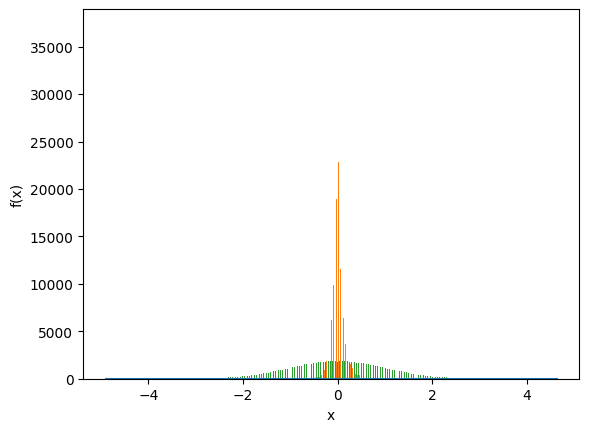

In [7]:
ip_reservoir.pre_train(X_TR, eta=0, epochs=0,  learning_rule="online", verbose=True) #16
ip_reservoir.predict(X_TR, save_gradients=False, save_states=True)
ip_reservoir.plot_global_neural_activity()

With the MG benchmark, such a strange behavior was observed, with the Pytorch KL divergence loss actually increasing, but the data distributuion visually becoming definetly "more Gaussian"

In [8]:
ip_reservoir.pre_train(X_TR, eta=0.00005, epochs=25,  learning_rule="online", verbose=True) #16

No transient applied. Reservoir was already warmed up
- Epoch: 1) | KL Divergence value: 1472.2464599609375.
- Epoch: 2) | KL Divergence value: 1509.5281982421875.
- Epoch: 3) | KL Divergence value: 1545.9761962890625.
- Epoch: 4) | KL Divergence value: 1581.7623291015625.
- Epoch: 5) | KL Divergence value: 1617.1142578125.
- Epoch: 6) | KL Divergence value: 1652.34326171875.
- Epoch: 7) | KL Divergence value: 1687.8270263671875.
- Epoch: 8) | KL Divergence value: 1723.9813232421875.
- Epoch: 9) | KL Divergence value: 1761.2216796875.
- Epoch: 10) | KL Divergence value: 1799.937744140625.
- Epoch: 11) | KL Divergence value: 1840.4659423828125.
- Epoch: 12) | KL Divergence value: 1883.080322265625.
- Epoch: 13) | KL Divergence value: 1927.9891357421875.
- Epoch: 14) | KL Divergence value: 1975.3353271484375.
- Epoch: 15) | KL Divergence value: 2025.1888427734375.
- Epoch: 16) | KL Divergence value: 2077.54541015625.
- Epoch: 17) | KL Divergence value: 2132.330322265625.
- Epoch: 18) | K

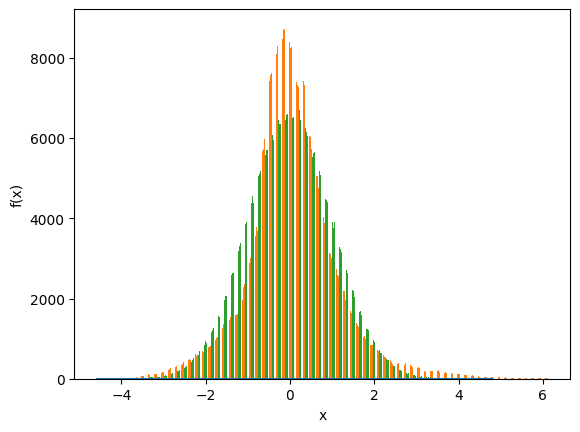

In [9]:
ip_reservoir.predict(X_TR, save_gradients=False, save_states=True)
ip_reservoir.sample_targets(X_TR.shape[0], overwrite=True)
ip_reservoir.plot_global_neural_activity()

In [10]:
ip_reservoir.predict(X_TS, save_gradients=False, save_states=True)
ip_reservoir.sample_targets(X_TS.shape[0], overwrite=True)

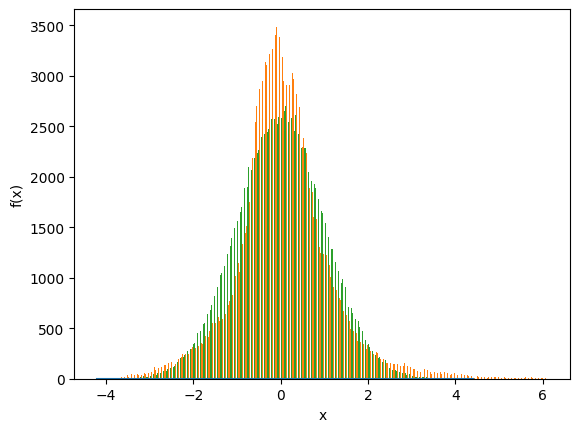

In [11]:
ip_reservoir.plot_global_neural_activity()

We can easily check our assumption about then reucrrent weight matrix eigenvalue and ESP, calculating the orignal $\rho$ of the recurrent weight matrix, we we have e priorly decided, and then the spectral radius $\rho_{ip}$ of the recurrent weight matrix scaled by the $a$ parameter of the IP algorithm.  

In [12]:
ip_reservoir.max_eigs(scaled=False)

tensor(0.2500)

In [13]:
ip_reservoir.max_eigs()

tensor(0.9680)

All units ar more or less focused around $net$ values of 0. Checking mean value and standard deviation for the whole reservoir in fact, we are more or less converging to a normal distribution, as desired.

In [14]:
ip_reservoir.print_IP_stats([0,12,25,37,46])

Unit - (1): [ ACTUAL_MEAN == (0.29307878017425537)  ACTUAL_STD == (0.9264146089553833)][ TARGET_MEAN == (0.013202731497585773) TARGET_STD == (0.9894354939460754)]
Unit - (13): [ ACTUAL_MEAN == (0.07529877871274948)  ACTUAL_STD == (0.4364461898803711)][ TARGET_MEAN == (-0.02147364430129528) TARGET_STD == (1.0120843648910522)]
Unit - (26): [ ACTUAL_MEAN == (-0.04624171182513237)  ACTUAL_STD == (0.3192448318004608)][ TARGET_MEAN == (-0.04016316682100296) TARGET_STD == (1.0038244724273682)]
Unit - (38): [ ACTUAL_MEAN == (-0.5315611362457275)  ACTUAL_STD == (1.2836387157440186)][ TARGET_MEAN == (0.012298797257244587) TARGET_STD == (0.9959365129470825)]
Unit - (47): [ ACTUAL_MEAN == (-0.009022055193781853)  ACTUAL_STD == (0.4758926331996918)][ TARGET_MEAN == (-0.022827567532658577) TARGET_STD == (0.9973897337913513)]
Overall network: [ACTUAL_MEAN == (0.0709385946393013)  ACTUAL_STD == (1.0755025148391724)]


## BIMODAL MIXTURE OF GAUSSIAN

Now its time to pre train the Bimodal IP reservoir. 

In [15]:
bimodal_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.mixedBimodalMask(N_UNITS), bias = True)

bimodal_reservoir.W_x = W_x
bimodal_reservoir.W_u = W_u
bimodal_reservoir.b_x = b_x
bimodal_reservoir.b_u = b_u

This time the KL divergence monotonically decrease. 

In [16]:
bimodal_reservoir.pre_train(X_TR, eta=0.0000025, epochs=15,  learning_rule="online", verbose=True)

- Epoch: 1) | KL Divergence value: 3347.36962890625.
- Epoch: 2) | KL Divergence value: 3075.8994140625.
- Epoch: 3) | KL Divergence value: 2829.86669921875.
- Epoch: 4) | KL Divergence value: 2611.020751953125.
- Epoch: 5) | KL Divergence value: 2419.767822265625.
- Epoch: 6) | KL Divergence value: 2255.40869140625.
- Epoch: 7) | KL Divergence value: 2116.44384765625.
- Epoch: 8) | KL Divergence value: 2000.84765625.
- Epoch: 9) | KL Divergence value: 1906.310302734375.
- Epoch: 10) | KL Divergence value: 1830.414306640625.
- Epoch: 11) | KL Divergence value: 1770.772705078125.
- Epoch: 12) | KL Divergence value: 1725.151123046875.
- Epoch: 13) | KL Divergence value: 1691.5953369140625.
- Epoch: 14) | KL Divergence value: 1668.5372314453125.
- Epoch: 15) | KL Divergence value: 1654.92724609375.


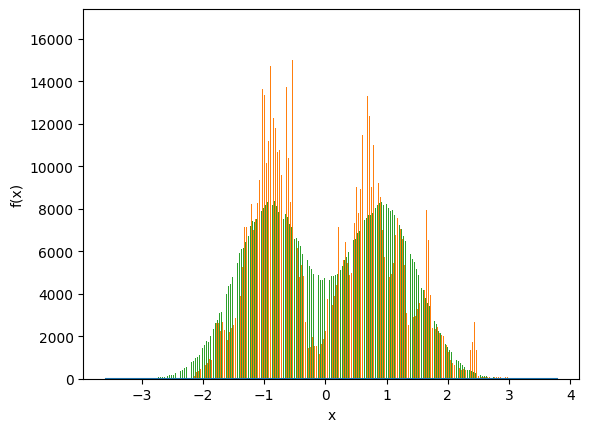

In [17]:
bimodal_reservoir.predict(X_TR, save_gradients=False, save_states=True)
bimodal_reservoir.plot_global_neural_activity()

In [18]:
bimodal_reservoir.predict(X_TS, save_gradients=False, save_states=True)
bimodal_reservoir.sample_targets(X_TS.shape[0], overwrite=True)

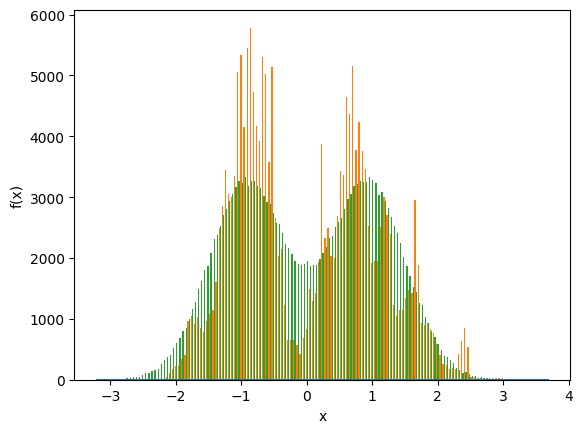

In [19]:
bimodal_reservoir.plot_global_neural_activity()

## ANALYZING THE EFFECTS OF BIMODAL IP 

The Bimodal Target seems to have had a softer impact on the spectral radius. 

In [20]:
ip_reservoir.max_eigs(scaled=False)

tensor(0.2500)

In [21]:
bimodal_reservoir.max_eigs(scaled=True)

tensor(0.4060)

Maybe such a low spectral radius can represent a "too high bias" for a powerful ESN, in such a case, an aposteriori weight rescaling may be taken in consideration. 

Another important observation that we can drive out, is that, along with the value of the KL divergence, the spectral radius can be used as an oracle for the pre trtaining progression and eventually become part of a stopping criteria. 

Observing the neural activity of the single units, the expected behavior of the masks seems to be more or less obtained, having some units focuesd around -1 and some other focused around +1. 

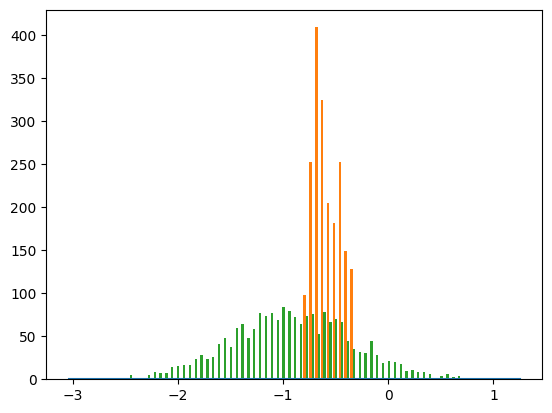

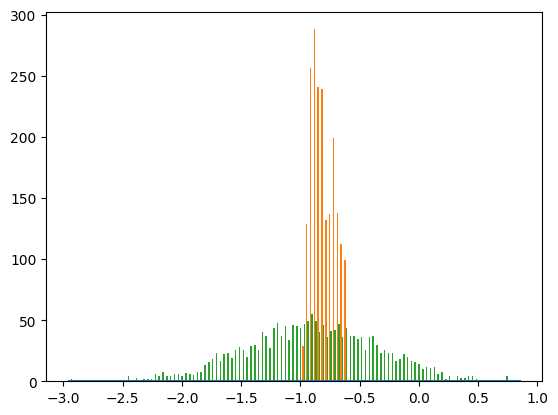

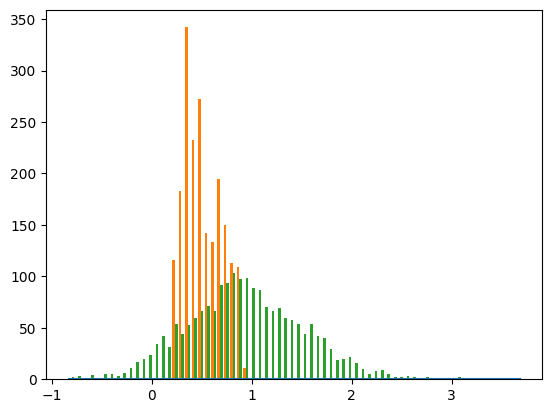

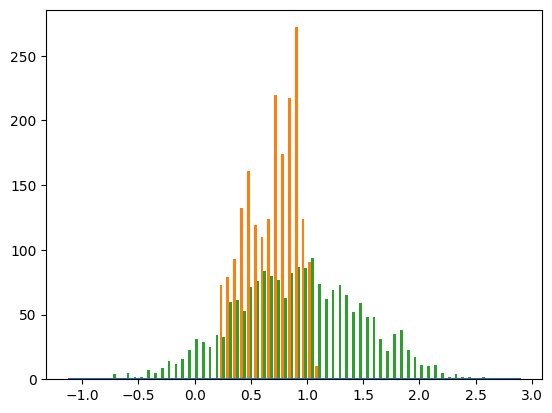

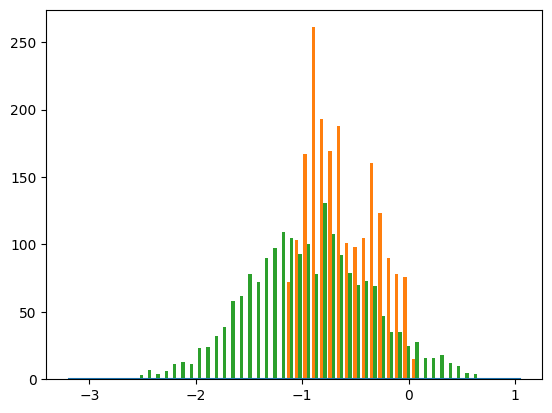

In [22]:
bimodal_reservoir.plot_local_neural_activity([0,12,25,37,46])

In [23]:
bimodal_reservoir.print_IP_stats([0,12,25,37,46])

Unit - (1): [ ACTUAL_MEAN == (-0.5802296996116638)  ACTUAL_STD == (0.12522602081298828)][ TARGET_MEAN == (-0.9315406680107117) TARGET_STD == (0.5776357650756836)]
Unit - (13): [ ACTUAL_MEAN == (-0.8035637736320496)  ACTUAL_STD == (0.09468832612037659)][ TARGET_MEAN == (-0.9078612923622131) TARGET_STD == (0.5643033981323242)]
Unit - (26): [ ACTUAL_MEAN == (0.5195961594581604)  ACTUAL_STD == (0.1869852989912033)][ TARGET_MEAN == (0.9253494143486023) TARGET_STD == (0.5839415192604065)]
Unit - (38): [ ACTUAL_MEAN == (0.6944600343704224)  ACTUAL_STD == (0.22191518545150757)][ TARGET_MEAN == (0.9071398973464966) TARGET_STD == (0.5748720169067383)]
Unit - (47): [ ACTUAL_MEAN == (-0.6155065894126892)  ACTUAL_STD == (0.3095698356628418)][ TARGET_MEAN == (-0.9459391236305237) TARGET_STD == (0.5905250906944275)]
Overall network: [ACTUAL_MEAN == (0.015523470006883144)  ACTUAL_STD == (1.0400896072387695)]


By the way, the overall mean value of the reservoir $net$ values is still around 0, prooving that the non-linarly positive and non linelarly negative units, compensate each other. 

## EVAUALTUION IN ESN

In the following section, the three reservoirs modeled until now, will be used to build and train three corresponding Echo State Networks. 

We will also compare performance of such network on the MG17 task, and then we will also compare them using the Lyapunov Exponents metric. 

In [24]:
from ESN import EchoStateNetwork

simple_esn = EchoStateNetwork(simple_reservoir)
ip_esn = EchoStateNetwork(ip_reservoir)
bimodal_esn = EchoStateNetwork(bimodal_reservoir)

from Metrics import MSE

No grid search is carried on, hence no regularization will be applied, letting the $\lambda$ value in the ridge regression always fixed to 0. 

NORMALIZED ROOT-MEAN SQUARE ERROR: 7.063396963647696e-08


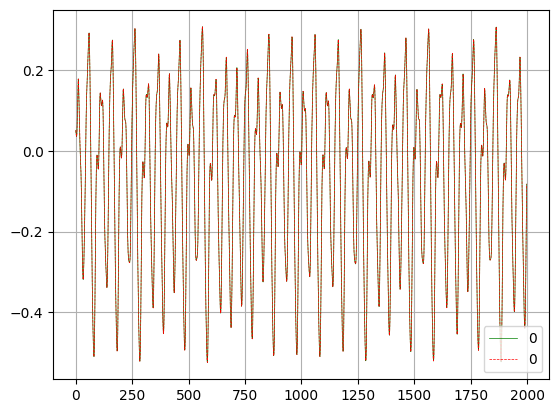

In [25]:
simple_esn.train(X_TR, Y_TR, 0, verbose=False)

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 4.473328519351427e-08


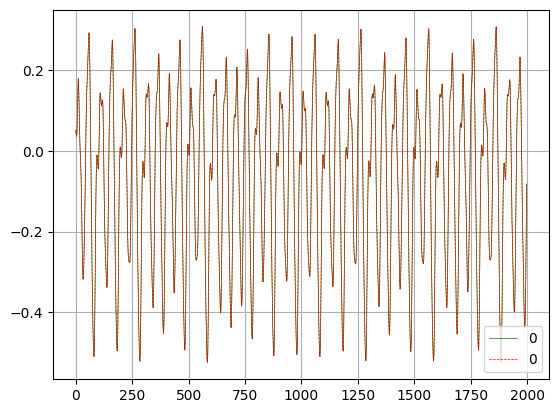

In [26]:
ip_esn.train(X_TR, Y_TR, 0, transient=100, verbose=False)

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 8.764277388304651e-08


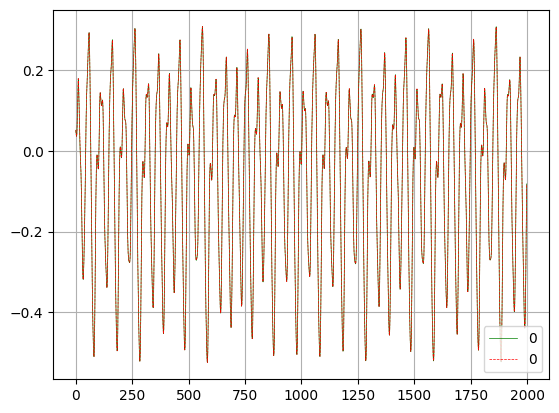

In [27]:
bimodal_esn.train(X_TR, Y_TR, 0, transient=100, verbose=False)

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

## LYAPUNOV EXPONENTS

In [28]:
simple_esn.reservoir.LCE(X_TS)

-1.3943331

In [29]:
ip_esn.reservoir.LCE(X_TS)

-0.763705

In [30]:
bimodal_esn.reservoir.LCE(X_TS)

-1.2322797

## MEMORY CAPACITY

In [31]:
def mean_mc(esn: EchoStateNetwork, rep):
    mc = 0
    for _ in range(rep):
        mc += esn.MemoryCapacity()

    return mc/rep

In [32]:
mean_mc(simple_esn, 5)

tensor(8.5619)

In [33]:
mean_mc(ip_esn, 5)

tensor(14.8132)

In [34]:
mean_mc(bimodal_esn, 5)

tensor(10.2496)

## DEVIATION FROM LINEARITY

In [35]:
simple_esn.reservoir.de_fi()

0.2303101174531356


In [36]:
ip_esn.reservoir.de_fi()

0.340945691366705


In [37]:
bimodal_esn.reservoir.de_fi()

0.23703460366649964
